In [59]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_labels, cq_filter
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [60]:
# load data
dataset = 'clinc150'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'
oos_label = 42

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds_oos = pd.read_csv(data_dir + "test_predictions.csv")
df_test_preds = df_test_preds_oos[df_test_preds_oos.label != oos_label]
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")
df_ood_preds = pd.read_csv(data_dir + "ood_predictions.csv")


labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)
N_INTENTS = len(labels)
N_INTENTS

151

In [61]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(10815, 3605, 3605)

In [62]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_test_oos = df_test_preds_oos.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})
df_ood = df_ood_preds.reset_index().rename(columns={'index': 'utterance'})


df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_test_oos['utterance'] = df_test_oos['utterance'].apply(lambda h: 'test_oos_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))
df_ood['utterance'] = df_ood['utterance'].apply(lambda h: 'ood_' + str(h))


df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_test_oos['utterance'] = df_test_oos['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)
df_ood['utterance'] = df_ood['utterance'].astype(str)

np.random.seed(42)
df_ood_shuffled = df_ood.sample(frac=1)
df_ood = pd.concat([df_test.sample(len(df_ood)), df_ood])
train_test_split = int(len(df_ood_shuffled)/2)

df_ood_calib = pd.concat([df_calibration.sample(int(len(df_ood) / 2)), df_ood_shuffled[train_test_split:]])
df_ood_test = pd.concat([df_test.sample(int(len(df_ood) / 2)), df_ood_shuffled[:train_test_split]])


In [63]:
# merge datasets to single frame
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

fullset_oos = pd.concat([df_test_oos, df_calibration], ignore_index=True)
assert fullset_oos.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset_oos = fullset_oos.drop(['label', 'hash', 'text'], axis=1)
fullset_oos.head()

fullset_ood = pd.concat([df_ood_shuffled, df_test, df_calibration], ignore_index=True)
assert fullset_ood.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset_ood = fullset_ood.drop(['label', 'hash', 'text'], axis=1)
fullset_ood.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_141,label_142,label_143,label_144,label_145,label_146,label_147,label_148,label_149,label_150
0,ood_1178,0.341469,0.001987,0.000455,0.000986,0.000420,0.006104,0.002576,0.002759,0.000398,...,0.001412,0.000562,0.000705,0.000273,0.001088,0.000852,0.002384,0.001941,0.003118,0.000781
1,ood_865,0.007140,0.001766,0.001861,0.007126,0.002718,0.010794,0.006143,0.008205,0.001842,...,0.006695,0.007121,0.001480,0.001237,0.001044,0.000377,0.006916,0.001546,0.001777,0.025767
2,ood_101,0.000767,0.000216,0.000118,0.000342,0.000324,0.000167,0.000514,0.000152,0.000653,...,0.000185,0.001367,0.001165,0.000376,0.002631,0.000111,0.000410,0.000949,0.002148,0.000468
3,ood_439,0.519965,0.001266,0.001017,0.002289,0.000876,0.005430,0.010444,0.002965,0.001152,...,0.001342,0.001255,0.001687,0.004605,0.004192,0.001337,0.002909,0.001486,0.002712,0.001297
4,ood_58,0.002840,0.000621,0.001084,0.001516,0.014272,0.022445,0.003602,0.006371,0.002220,...,0.001869,0.000865,0.000302,0.000386,0.002468,0.001816,0.001602,0.000527,0.003142,0.002135


In [64]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]
X_test_oos = df_test_oos['utterance']
X_ood = df_ood[['utterance']]
X_ood_calib = df_ood_calib[['utterance']]
X_ood_test = df_ood_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .01
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [65]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False, classes=list(range(151)))
# fit the test dataset
model.fit(X_test, df_test['label'])
# extract the test targets from the datasets
y_test = df_test['label']

# instantiate a mock sklearn model which simply looks up the results in a lookup table
model_oos = MockModel(fullset_oos, 'utterance', softmax=False, classes=list(range(151)))
model_ood = MockModel(fullset_ood, 'utterance', softmax=False, classes=list(range(151)))
# fit the test dataset
model_oos.fit(X_test_oos, df_test_oos['label'])
# extract the test targets from the datasets
y_test_oos = df_test_oos['label']
y_test_oos = df_test_oos['label']
y_ood = df_ood['label']
y_calib = df_calibration['label']
y_ood_calib = df_ood_calib['label']
y_ood_test = df_ood_test['label']

In [66]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model_ood, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
in_sample = y_test != oos_label
selection = in_sample
# selection = [True,] * len(y_test)

results = cq_stats(y_ps_marginal[selection, :, target_index], y_test[selection], max_ps_size)

results
write_results('clinc150-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9877879544823758,
 0.9664355062413315,
 2.6638655462184873,
 0.0011095700416088765)

In [67]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[selection, :, target_index], y_test[selection], max_ps_size)

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(


(0.9959028387474392,
 0.8929264909847434,
 3.0353535353535355,
 0.05464632454923717)

In [68]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(
/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9905686546463246, 0.0, 2.0, 0.0)

In [69]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

raps_stats = cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)
raps_stats

/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(


(0.9936199722607489, 0.8244105409153952, 3.4123222748815167, 0.0)

In [12]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)

results = cq_stats(y_ps_h1[selection], y_test[selection], max_ps_size)
write_results('clinc150-bert-h1', dataset, intent_classifier, 'h1', results)
results_h1 = results

(0.9947295423023579, 0.8199722607489598, 5.0, 0.0)

In [13]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)

results = cq_stats(y_ps_h2[selection], y_test[selection], max_ps_size)
write_results('clinc150-bert-h2', dataset, intent_classifier, 'h2', results)
results_h2 = results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9791955617198336, 1.0, nan, 0.0)

In [14]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results = cq_stats(y_ps_h3[selection], y_test[selection], max_ps_size)
write_results('clinc150-bert-h3', dataset, intent_classifier, 'h3', results)
results_h3 = results

(0.996116504854369, 0.0, 5.0, 0.0)

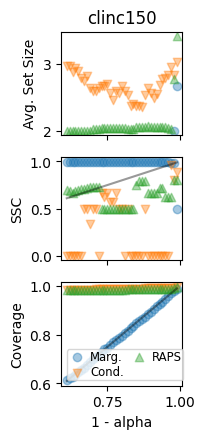

In [75]:
plot.plot_coverages_widths_multi(
        alpha,
        [
            coverages_marginal,
            coverages_adaptive,
            coverages_raps,
            ],
        [
            cqsize_marginal,
            cqsize_adaptive,
            cqsize_raps
            ],
        ['Marg.', 'Cond.', 'RAPS'],
        legend=(2, 'lower left'),
        sscs=[
            ssc_marginal,
            ssc_adaptive,
            ssc_raps,
        ],
        # hlines=(
        #     (results_h1[0], ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
        #     (widths_mean_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
        #     (widths_mean_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
        # ),
        plot_ssc=True,
        markers=('o', 'v', '^',),
        dataset=dataset,
        model=intent_classifier,
        title="C150"
)

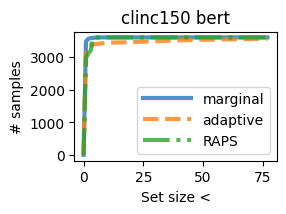

In [15]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [16]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) > max_ps_size))
ambiguous = df_test.loc[ambiguous_indices]
len(list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist())))

2

In [17]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

book 3 under the name zebee at xenophobe & restaurant reservation & restaurant reviews, order, change ai name, todo list update, order status, calendar update, goodbye, fun fact \\
i cracked my card, order a new one & damaged card & report lost card, order, card declined, order status, damaged card, replacement card duration, pay bill, order checks \\


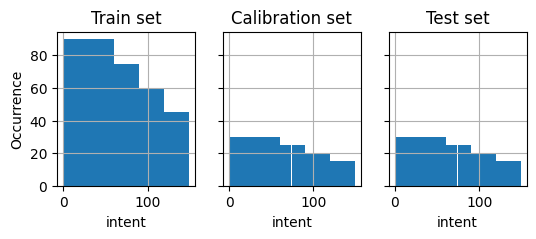

In [18]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [19]:
len(label_sorting_map)

151

In [20]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [50]:
def to_oos(y_pred_set, max_ps_size):
    return y_pred_set.sum(axis=1) > max_ps_size

def to_oos_score(y_pred_set):
    return y_pred_set.sum(axis=1) / N_INTENTS

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay

mapie_marginal_ood = MapieClassifier(estimator=model_ood, cv="prefit", method="score", random_state=42)
mapie_marginal_ood.fit(X_calib, df_calibration['label'])

a_start = 1 / y_ood.shape[0]
a_stop = .01
a_step = 0.001
alpha = np.arange(a_start, a_stop, a_step)
y_pred_marginal_ood, y_ps_marginal_ood = mapie_marginal_ood.predict(X_ood_calib, alpha=alpha)

f1s = []
aucs = []
for i in range(len(alpha)):
    target_index_ood = i

    y_pred_ood = to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size)
    y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size) for max_ps_size in range(12)]

    y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, target_index_ood])
    y_true_ood = y_ood_calib == oos_label

    y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
    f1s.append(max(y_preds_ood_f1s))
    aucs.append(roc_auc_score(y_true_ood, y_pred_ood_score))

f1s = np.array(f1s)
aucs = np.array(aucs)

selected_alpha_index = f1s.argmax()
print(f"select alpha = {alpha[selected_alpha_index]} at index {selected_alpha_index} with f1 = {f1s[selected_alpha_index]} and auc = {aucs[selected_alpha_index]}")

select alpha = 0.004416666666666667 at index 4 with f1 = 0.9106239460370995 and auc = 0.9692902777777778


/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(


In [51]:
1-0.004416666666666667

0.9955833333333334

In [52]:
f1s = np.array(f1s)

y_pred_ood = to_oos(y_ps_marginal_ood[:, :, selected_alpha_index], max_ps_size)
y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, selected_alpha_index], max_ps_size) for max_ps_size in range(50)]

y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, 1])
y_true_ood = y_ood_calib == oos_label
y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
optimal_threshold = np.array(y_preds_ood_f1s).argmax()
print(f"optimal threshold at {optimal_threshold} in calibration set")

optimal threshold at 6 in calibration set


F1 OOD on test set: 0.9054054054054055, AUC OOD on test set: 0.9701833333333334


/Users/floris/miniconda3/envs/cicc/lib/python3.12/site-packages/mapie/classification.py:956: UserWarning: WARNING: your calibration dataset has less labels than your training dataset (training has 151 unique labels while calibration have 150 unique labels
  warnings.warn(


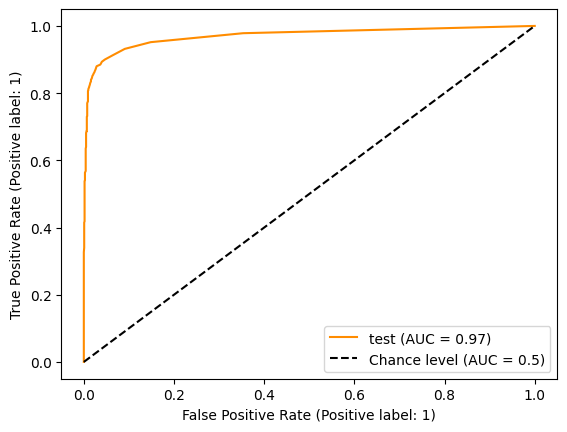

In [53]:
# marginal conformal prediction
mapie_marginal_ood = MapieClassifier(estimator=model_ood, cv="prefit", method="score", random_state=42)
mapie_marginal_ood.fit(X_calib, df_calibration['label'])

a_start = 1 / y_ood.shape[0]
a_stop = .01
a_step = 0.001
alpha = np.arange(a_start, a_stop, a_step)
y_pred_marginal_ood, y_ps_marginal_ood = mapie_marginal.predict(X_ood_test, alpha=alpha)

target_index_ood = selected_alpha_index

y_pred_ood = to_oos(y_ps_marginal_ood[:, :, target_index_ood], optimal_threshold)
y_preds_ood = [to_oos(y_ps_marginal_ood[:, :, target_index_ood], max_ps_size) for max_ps_size in range(50)]

y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, target_index_ood])
y_true_ood = y_ood_test == oos_label

y_preds_ood_f1s = [f1_score(y_true_ood, pred) for pred in y_preds_ood]
f1_ood_test = f1_score(y_true_ood, y_pred_ood)
auc_ood_test = roc_auc_score(y_true_ood, y_pred_ood_score)
print(f"F1 OOD on test set: {f1_ood_test}, AUC OOD on test set: {auc_ood_test}")

RocCurveDisplay.from_predictions(
    y_true_ood,
    y_pred_ood_score,
    name="test",
    color="darkorange",
    plot_chance_level=True,
)


In [24]:
X_ood_test

,utterance
1641,test_1755
571,test_613
129,test_138
3443,test_3674
3596,test_3835
...,...
530,ood_530
90,ood_90
1161,ood_1161
181,ood_181


In [25]:
f1s[0], aucs[0]

(0.5, 0.973875)

In [26]:
f1s = np.array(f1s)
aucs = np.array(aucs)
f1s.max(), f1s.argmax(), aucs.max(), aucs.argmax()

(0.9106239460370995, 4, 0.973875, 0)

In [27]:
f1s.max()

0.9106239460370995

In [28]:
y_pred_ood = to_oos(y_ps_marginal_ood[:, :, 0], max_ps_size)
y_pred_ood_score = to_oos_score(y_ps_marginal_ood[:, :, 0])



(array([190., 274., 224., 161.,  84.,  63.,  45.,  43.,  17.,  25.,  24.,
         18.,   6.,  10.,   8.,   4.,   5.,   6.,   4.,   4.,   4.,   5.,
          0.,   1.,   0.,   1.,   3.,   2.,   0.,   3.,   0.,   2.,   0.,
          4.,   3.,   0.,   2.,   2.,   3.,   1.,   2.,   1.,   5.,   1.,
          1.,   1.,   0.,   0.,   0.,   1.,   3.,   4.,   1.,   3.,   3.,
          0.,   3.,   1.,   0.,   0.,   3.,   2.,   1.,   0.,   0.,   0.,
          0.,   2.,   0.,   2.,   1.,   1.,   1.,   2.,   1.,   3.,   3.,
          1.,   0.,   2.,   1.,   2.,   0.,   1.,   0.,   2.,   3.,   1.,
          1.,   3.,   0.,   1.,   1.,   3.,   2.,   1.,   1.,   2.,   2.,
          0.,   3.,   1.,   1.,   0.,   1.,   1.,   2.,   0.,   0.,   2.,
          4.,   0.,   2.,   1.,   0.,   3.,   2.,   5.,   3.,   4.,   2.,
          1.,   1.,   4.,   2.,   6.,   5.,   7.,   2.,   2.,   2.,   3.,
          2.,   6.,   6.,   7.,   7.,   9.,   5.,   5.,   6.,   9.,   6.,
          9.,  10.,  17.,  18.,  27., 

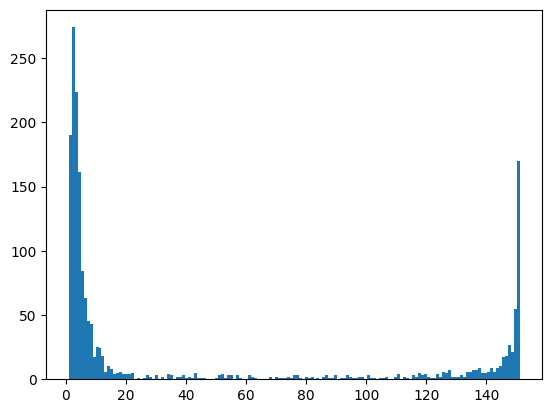

In [29]:
plt.hist(y_ps_marginal_ood[:, :, 1].sum(axis=1), bins=N_INTENTS)

In [30]:
cicc_pred_ood = np.where(y_ps_marginal_ood[:, :, 1].sum(axis=1) > optimal_threshold)[0]
cicc_pred_id = np.where(y_ps_marginal_ood[:, :, 1].sum(axis=1) <= optimal_threshold)[0]

# accuracy
((y_ood.iloc[cicc_pred_ood] == 42).sum() + (y_ood.iloc[cicc_pred_id] != 42).sum()) / y_ood.shape[0]

0.645

In [31]:
cicc_pred_ood

array([   6,   18,   22,   24,   28,   41,   45,   50,   52,   65,   68,
         69,   70,   78,   81,   83,   84,   89,   91,  107,  109,  115,
        118,  122,  124,  137,  138,  142,  146,  149,  155,  174,  175,
        183,  185,  190,  197,  204,  213,  214,  220,  243,  248,  250,
        253,  259,  260,  263,  266,  268,  276,  282,  283,  291,  302,
        303,  304,  308,  309,  311,  328,  339,  343,  348,  374,  385,
        387,  396,  401,  402,  406,  412,  421,  431,  432,  435,  437,
        439,  440,  442,  446,  455,  457,  464,  471,  474,  477,  481,
        485,  491,  493,  496,  497,  501,  510,  520,  524,  525,  526,
        532,  534,  535,  546,  549,  560,  562,  563,  565,  568,  571,
        575,  588,  593,  603,  604,  605,  606,  612,  615,  617,  618,
        621,  627,  630,  635,  640,  654,  660,  661,  666,  679,  689,
        690,  696,  700,  704,  710,  712,  714,  718,  722,  724,  727,
        730,  732,  735,  743,  756,  757,  774,  7

In [32]:
y_ood.shape

(2400,)

In [33]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')

In [34]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal_ood[:, :, -1], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}_ood.csv')

In [35]:
set_size_equals(y_ps_marginal_ood[:, :, -1], 1)

1276

In [36]:
y_ps_marginal_ood

array([[[False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [37]:
a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .01
target_index = index_for_arange(a_start, a_step ,target_alpha)
y_pred_marginal_vood, y_ps_marginal_vood = mapie_marginal.predict(X_ood_test, alpha=alpha)

y_pred_vood = to_oos(y_ps_marginal_vood[:, :, target_index], max_ps_size)
y_preds_vood = [to_oos(y_ps_marginal_vood[:, :, target_index], max_ps_size) for max_ps_size in range(50)]

y_pred_vood_score = to_oos_score(y_ps_marginal_vood[:, :, target_index])
y_true_vood = y_ood_test == oos_label

f1_vood_test = f1_score(y_true_vood, y_pred_vood)
auc_vood_test = roc_auc_score(y_true_vood, y_pred_vood_score)
print(f"F1 OOD on test set: {f1_vood_test}, AUC OOD on test set: {auc_vood_test}")


F1 OOD on test set: 0.0676328502415459, AUC OOD on test set: 0.8781819444444445
